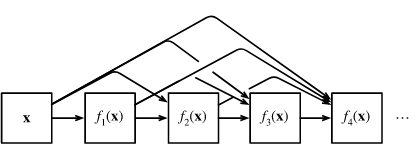

In [1]:
import keras
import math
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers import SeparableConv2D,Conv2D, Dense, Input, add, Activation, AveragePooling2D, GlobalAveragePooling2D, Lambda, concatenate
from keras.initializers import he_normal
from keras.layers.merge import Concatenate
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.models import Model
from keras.optimizers import *
from keras.regularizers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Download Dataset

In [46]:
(X_train,y_train),(X_test,y_test)=cifar10.load_data()

In [47]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

# Learning scheduler

In [ ]:
def learning_scheduler(epoch):
    if epoch < 150:
        return 0.1
    if epoch < 225:
        return 0.01
    return 0.001

# ***Part A***
# Define Model

In [ ]:
def conv(x, out_filters, k_size):
    return(SeparableConv2D(filters=out_filters,kernel_size=k_size,strides=(1,1), padding='same',kernel_initializer='he_normal', 
                  kernel_regularizer=l2(weight_decay),use_bias=False)(x))

def dense_layer(x):
    return(Dense(units=classes_num,
                    activation='softmax',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(weight_decay))(x))

def bn_relu(x):
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return(x)

def bottleneck_layer(x):
    channels = growth_rate * 4
    x = bn_relu(x)
    x = conv(x, channels, (1,1))
    x = bn_relu(x)
    x = conv(x, growth_rate, (3,3))
    return(x)

def single(x):
    x = bn_relu(x)
    x = conv(x, growth_rate, (3,3))
    return(x)

def transition(x, inchannels):
    outchannels = int(inchannels * compression)
    x = bn_relu(x)
    x = conv(x, outchannels, (1,1))
    x = AveragePooling2D((2,2), strides=(2, 2))(x)
    return(x, outchannels)

def dense_block(x,blocks,nchannels):
    concat = x
    for i in range(blocks):
        x = bottleneck_layer(concat)
        concat = concatenate([x,concat], axis=-1)
        nchannels += growth_rate
    return(concat, nchannels)
def densenet(img_input,classes_num,depth,growth_rate,compression):
    nblocks = (depth - 4) // 6 
    nchannels = growth_rate * 2
    x = conv(img_input, nchannels, (3,3))
    x, nchannels = dense_block(x,nblocks,nchannels)
    x, nchannels = transition(x,nchannels)
    x, nchannels = dense_block(x,nblocks,nchannels)
    x, nchannels = transition(x,nchannels)
    x, nchannels = dense_block(x,nblocks,nchannels)
    x = bn_relu(x)
    x = GlobalAveragePooling2D()(x)
    x = dense_layer(x)
    return(Model(img_input,x))

# Hyperparameters

In [ ]:
growth_rate= 12 
depth = 64
compression = 0.5
batch_size = 64 
nb_epochs = 50
iterations = 200
classes_num = 10
weight_decay = 1e-4

In [ ]:
model = densenet(Input(shape=X_train.shape[1:]),10,depth,growth_rate,compression)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 32, 32, 24)  99          ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 24)  96          ['separable_conv2d[0][0]']       
 alization)                                                                                       
                                                                                              

In [ ]:
tb_cb     = TensorBoard(log_dir='./densenet/', histogram_freq=0)
change_lr = LearningRateScheduler(learning_scheduler)
ckpt      = ModelCheckpoint('./ckpt.h5', save_best_only=False, mode='auto', period=10)
cbks      = [change_lr,tb_cb,ckpt]

In [ ]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [ ]:
sgd = SGD(lr=.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        epochs=nb_epochs,
                        validation_data=(X_test, y_test),callbacks=cbks,steps_per_epoch=iterations,
                        workers=4)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


200/200 [==============================] - 71s 282ms/step - loss: 1.8027 - accuracy: 0.3249 - val_loss: 1.6238 - val_accuracy: 0.3945 - lr: 0.1000
Epoch 2/50
200/200 [==============================] - 53s 267ms/step - loss: 1.3884 - accuracy: 0.4959 - val_loss: 1.4887 - val_accuracy: 0.4693 - lr: 0.1000
Epoch 3/50
200/200 [==============================] - 55s 275ms/step - loss: 1.1712 - accuracy: 0.5784 - val_loss: 2.3866 - val_accuracy: 0.3691 - lr: 0.1000
Epoch 4/50
200/200 [==============================] - 53s 266ms/step - loss: 1.0362 - accuracy: 0.6363 - val_loss: 1.1207 - val_accuracy: 0.6042 - lr: 0.1000
Epoch 5/50
200/200 [==============================] - 56s 278ms/step - loss: 0.9853 - accuracy: 0.6510 - val_loss: 1.0228 - val_accuracy: 0.6344 - lr: 0.1000
Epoch 6/50
200/200 [==============================] - 53s 266ms/step - loss: 0.8966 - accuracy: 0.6862 - val_loss: 1.1112 - val_accuracy: 0.6162 - lr: 0.1000
Epoch 7/50
200/200 [==============================] - 53s 266ms

# save model

In [2]:
import joblib

In [ ]:
joblib.dump(model, 'DenseNet_partA.sav')

INFO:tensorflow:Assets written to: ram://be280826-4042-4890-b69b-4a33e65fcad0/assets


['DenseNet_partA.sav']

# Plot results

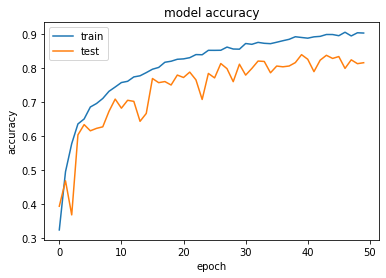

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

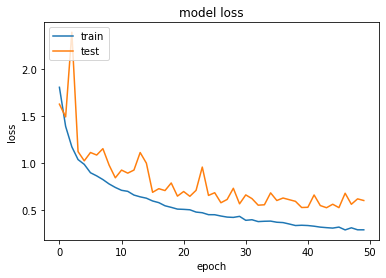

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Show wrong results

In [6]:
loaded_model = joblib.load('DenseNet_partA.sav')

In [49]:
class_string = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
X_test.shape

(10000, 32, 32, 3)

In [60]:
a = loaded_model.predict(X_test[10:11,:,:,:])
print(a)

[[9.8865950e-01 5.4659705e-07 3.7572940e-04 4.8368791e-04 8.1372038e-03
  1.3126583e-03 7.2057046e-06 9.0775598e-04 1.1392854e-04 1.8534023e-06]]


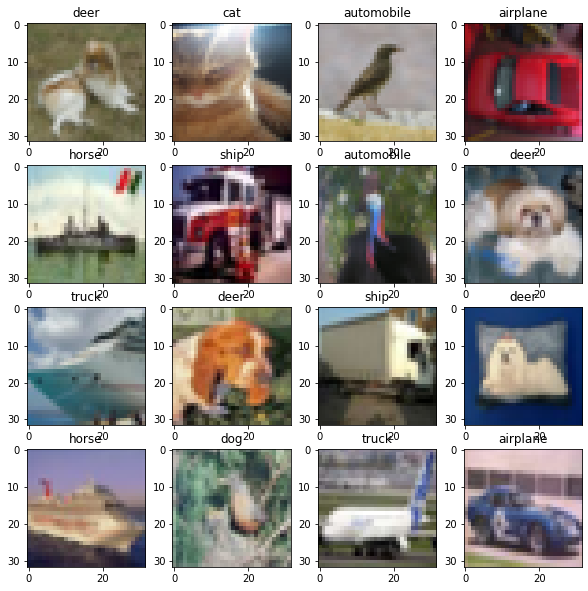

In [70]:
# plot some instance from dataset
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (10,10))

for i in range(4):
    for j in range(4):

        while(True):
            idx = np.random.randint(1, len(X_test))
            y_true = np.argmax(y_test[np.argmax(y_test[idx-1])])    
            y_pred = np.argmax(loaded_model.predict(X_test[idx-1:idx,:,:,:]))

            if (y_true == y_pred):
                continue
            else:
                break


        axs[i, j].imshow(X_test[idx-1:idx,:,:,:][0])
        axs[i, j].title.set_text(str(class_string[y_pred-1]))

plt.show()

# Part B

In [ ]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate

In [ ]:
def conv(x, out_filters, k_size):
    return(SeparableConv2D(filters=out_filters,kernel_size=k_size,strides=(1,1), padding='same',kernel_initializer='he_normal', 
                  kernel_regularizer=l2(weight_decay),use_bias=False)(x))

def dense_layer(x):
    return(Dense(units=classes_num,
                    activation='softmax',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(weight_decay))(x))

def bn_relu(x):
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return(x)

    #def bottleneck_layer(x):
    # inception
    # function for creating a projected inception module
def inception_module(layer_in):
	# 1x1 conv
    f1, f2_in, f2_out, f3_in, f3_out, f4_out = 32, 48, 64, 8, 16, 16 #64, 96, 128, 16, 32, 32

    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

	# 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv

    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling

    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last

    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out
    # channels = growth_rate * 4
    # x = bn_relu(x)
    # x = conv(x, channels, (1,1))
    # x = bn_relu(x)
    # x = conv(x, growth_rate, (3,3))
    # return(x)

def single(x):
    x = bn_relu(x)
    x = conv(x, growth_rate, (3,3))
    return(x)

def transition(x, inchannels):
    outchannels = int(inchannels * compression)
    x = bn_relu(x)
    x = conv(x, outchannels, (1,1))
    x = AveragePooling2D((2,2), strides=(2, 2))(x)
    return(x, outchannels)

def dense_block(x,blocks,nchannels):
    concat = x
    for i in range(blocks):
        x = inception_module(concat)
        concat = concatenate([x,concat], axis=-1)
        nchannels += growth_rate
    return(concat, nchannels)
def densenet(img_input,classes_num,depth,growth_rate,compression):
    nblocks = (depth - 4) // 6 
    nchannels = growth_rate * 2
    x = conv(img_input, nchannels, (3,3))
    x, nchannels = dense_block(x,nblocks,nchannels)
    x, nchannels = transition(x,nchannels)
    x, nchannels = dense_block(x,nblocks,nchannels)
    x, nchannels = transition(x,nchannels)
    x, nchannels = dense_block(x,nblocks,nchannels)
    x = bn_relu(x)
    x = GlobalAveragePooling2D()(x)
    x = dense_layer(x)
    return(Model(img_input,x))

In [ ]:
model = densenet(Input(shape=X_train.shape[1:]),10,depth,growth_rate,compression)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 separable_conv2d_3 (SeparableC  (None, 32, 32, 24)  99          ['input_2[0][0]']                
 onv2D)                                                                                           
                                                                                                  
 conv2d_181 (Conv2D)            (None, 32, 32, 48)   1200        ['separable_conv2d_3[0][0]']     
                                                                                                  
 conv2d_183 (Conv2D)            (None, 32, 32, 8)    200         ['separable_conv2d_3[0][0]'

In [ ]:
tb_cb     = TensorBoard(log_dir='./densenet/', histogram_freq=0)
change_lr = LearningRateScheduler(learning_scheduler)
ckpt      = ModelCheckpoint('./ckpt.h5', save_best_only=False, mode='auto', period=10)
cbks      = [change_lr,tb_cb,ckpt]

In [ ]:
datagen = ImageDataGenerator()
datagen.fit(X_train)

In [ ]:
sgd = SGD(lr=.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        epochs=nb_epochs,
                        validation_data=(X_test, y_test),callbacks=cbks,steps_per_epoch=iterations,
                        workers=4)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


200/200 [==============================] - 385s 2s/step - loss: 2.5757 - accuracy: 0.2344 - val_loss: 434164320.0000 - val_accuracy: 0.1000 - lr: 0.1000
Epoch 2/50
200/200 [==============================] - 344s 2s/step - loss: 1.6716 - accuracy: 0.3963 - val_loss: 7791.1313 - val_accuracy: 0.4147 - lr: 0.1000
Epoch 3/50
200/200 [==============================] - 359s 2s/step - loss: 1.5093 - accuracy: 0.4577 - val_loss: 1588.7430 - val_accuracy: 0.4102 - lr: 0.1000
Epoch 4/50
200/200 [==============================] - 359s 2s/step - loss: 1.3950 - accuracy: 0.5022 - val_loss: 22697.2949 - val_accuracy: 0.4259 - lr: 0.1000
Epoch 5/50
200/200 [==============================] - 344s 2s/step - loss: 1.3121 - accuracy: 0.5394 - val_loss: 1234347.7500 - val_accuracy: 0.5147 - lr: 0.1000
Epoch 6/50
200/200 [==============================] - 358s 2s/step - loss: 1.2446 - accuracy: 0.5605 - val_loss: 140054.8438 - val_accuracy: 0.4929 - lr: 0.1000
Epoch 7/50
200/200 [==========================

# Part C

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.125,height_shift_range=0.125,fill_mode='nearest',cval=0.,zoom_range = 0.1)
datagen.fit(X_train)

In [ ]:
sgd = SGD(lr=.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        epochs=nb_epochs,
                        validation_data=(X_test, y_test),callbacks=cbks,steps_per_epoch=iterations,
                        workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
200/200 [==============================] - 75s 278ms/step - loss: 1.8806 - accuracy: 0.3000 - val_loss: 1.9201 - val_accuracy: 0.3111 - lr: 0.1000
Epoch 2/50
200/200 [==============================] - 53s 267ms/step - loss: 1.6026 - accuracy: 0.4101 - val_loss: 1.5580 - val_accuracy: 0.4286 - lr: 0.1000
Epoch 3/50
200/200 [==============================] - 55s 274ms/step - loss: 1.4278 - accuracy: 0.4883 - val_loss: 1.6197 - val_accuracy: 0.4460 - lr: 0.1000
Epoch 4/50
200/200 [==============================] - 54s 267ms/step - loss: 1.2750 - accuracy: 0.5415 - val_loss: 1.5773 - val_accuracy: 0.4666 - lr: 0.1000
Epoch 5/50
200/200 [==============================] - 53s 264ms/step - loss: 1.1494 - accuracy: 0.5949 - val_loss: 1.5685 - val_accuracy: 0.5300 - lr: 0.1000
Epoch 6/50
200/200 [==============================] - 55s 273ms/step - loss: 1.1031 - accuracy: 0.6138 - val_loss: 1.3867 - val_accuracy: 0.5369 - lr: 0.1000
Epoch 7/50
200/200 [==============================] 

In [ ]:
joblib.dump(model, 'DenseNet_partB.sav')

INFO:tensorflow:Assets written to: ram://36bfc6a1-db15-4a5f-8bdb-8014812cd9f7/assets


['DenseNet_partB.sav']

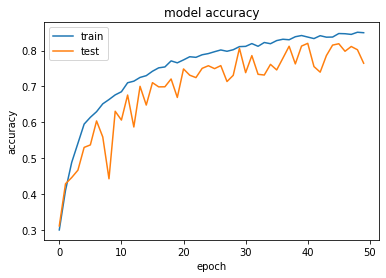

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

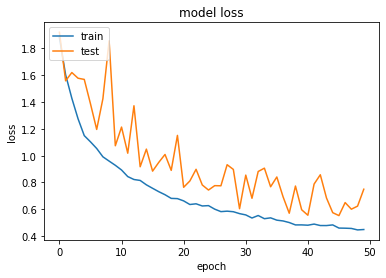

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
loaded_model = joblib.load('DenseNet_partC.sav')

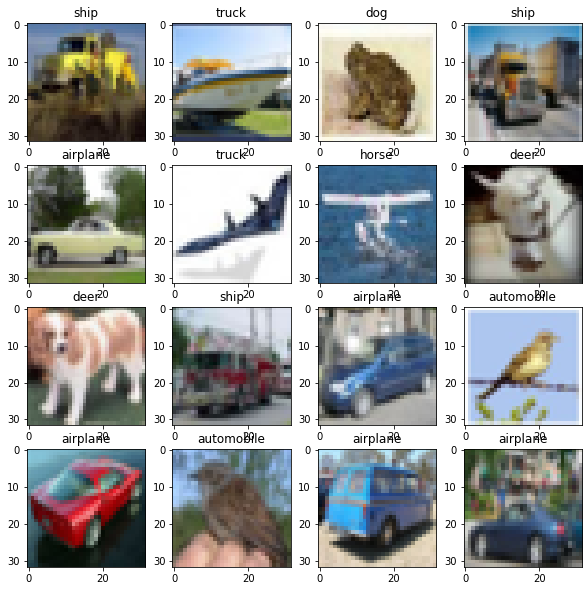

In [72]:
# plot some instance from dataset
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (10,10))

for i in range(4):
    for j in range(4):

        while(True):
            idx = np.random.randint(1, len(X_test))
            y_true = np.argmax(y_test[np.argmax(y_test[idx-1])])    
            y_pred = np.argmax(loaded_model.predict(X_test[idx-1:idx,:,:,:]))

            if (y_true == y_pred):
                continue
            else:
                break


        axs[i, j].imshow(X_test[idx-1:idx,:,:,:][0])
        axs[i, j].title.set_text(str(class_string[y_pred-1]))

plt.show()